# Tutorial 06: CommonOcean Curvilinear Coordinatesystem

This tutorial shows you how to create a **curvilinear coordinate system** using CommonOcean scenarios.
The curvilinear coordinate system is aligned with a given reference path. Any point (x,y) in the cartesian frame is described by the coordinates (s,d) in the curvilinear frame,
where s is the arc length along the reference path and d the lateral deviation to the reference path.

Before starting this tutorial, make sure that you have gone through the tutorial for CommonOcean-IO and have installed all necessary dependencies according to the installation manual.

## 1. Preparation
We begin by importing all required modules for this tutorial.

In [1]:
%matplotlib inline
import os

import numpy as np
import matplotlib.pyplot as plt

# commonocean-io imports
from commonocean.common.file_reader import CommonOceanFileReader
from commonocean.visualization.draw_dispatch_cr import draw_object

from commonroad_dc.pycrccosy import CurvilinearCoordinateSystem

# commonocean-dc import
from commonocean_dc.geometry.util import chaikins_corner_cutting, resample_polyline


## 2. Load CommonRoad scenario
We load the CommonRoad scenario for which we want to create a curvilinear coordinate system.

In [2]:
# load the CommonOcean scenario, note that you might have to modify the path to the CommonOcean scenario!
file_path = os.path.join(os.getcwd(), 'CommonOceanDC_Tutorial.xml')

scenario, planning_problem_set = CommonOceanFileReader(file_path).open()

## 3. Create a reference path for the coordinate system
We need to generate a reference path to construct the curvilinear coordinate system. A reference path can be any polyline, e.g., the centerline of a waterway path or a route obtained with a route planner.

For demonstration purposes, we manually define certain vertices to create the reference path in this tutorial.

In [3]:
ref_path = []
for i_1 in range(400,0,-1):
    ref_path.append([-i_1, -400.0])
for i_2 in range(400,0,-1):
    ref_path.append([(400-i_2)*1.1, -i_2])

ref_path = np.array(ref_path)

We visualize the scenario and the generated reference path. The centerline (i.e., reference path) is shown in green.

/home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_sign.py:159: UserWarning: No png file for traffic sign id TrafficSignElementID.LATERAL_MARK_RED_A exists under path /home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_signs/101.png, skipped plotting.
  warnings.warn(


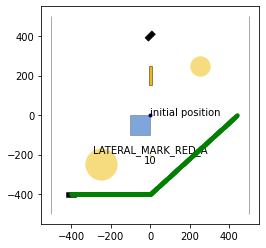

/home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_sign.py:159: UserWarning: No png file for traffic sign id TrafficSignElementID.LATERAL_MARK_RED_A exists under path /home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_signs/101.png, skipped plotting.
  warnings.warn(


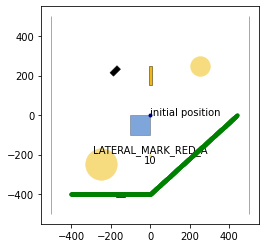

/home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_sign.py:159: UserWarning: No png file for traffic sign id TrafficSignElementID.LATERAL_MARK_RED_A exists under path /home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_signs/101.png, skipped plotting.
  warnings.warn(


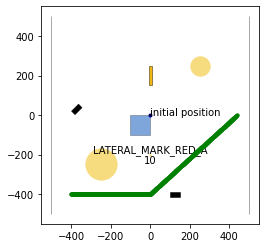

/home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_sign.py:159: UserWarning: No png file for traffic sign id TrafficSignElementID.LATERAL_MARK_RED_A exists under path /home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_signs/101.png, skipped plotting.
  warnings.warn(


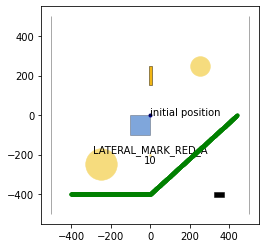

In [4]:
# draw scenario
for j in [0,50, 105, 150]:
    draw_object(scenario, draw_params={'time_begin': j, 'trajectory_steps': 0})
    draw_object(planning_problem_set, draw_params={'time_begin': j})
    plt.gca().set_aspect('equal')
    plt.plot(ref_path[:,0], ref_path[:,1], zorder=100, marker='.', color='green')
    plt.show()

# draw reference path

## 4. Create the curvilinear coordinate system

As can be seen in the visualization above, the reference path is jagged in some places. Therefore, we preprocess the
reference path before creating the coordinate system: We smoothen the polyline using Chaikins corner cutting algorithm
followed by resampling of the polyline every 2m. Then, we are able to create the curvilinear coordinate system based on
the preprocessed reference path.

In [5]:
# we apply chaikins corner cutting 10 times to smoothen the reference path
for i in range(0, 10):
    ref_path = chaikins_corner_cutting(ref_path)
ref_path = resample_polyline(ref_path, 2.0)

# create curvilinear CoSy
curvilinear_cosy = CurvilinearCoordinateSystem(ref_path, 50, 0.1)

## 5. Project position onto curvilinear frame

Now, we can convert coordinates from the Cartesian frame to the curvilinear coordinate system and vice versa.

In [6]:
# original cartesian point
p_cartesian = np.array([425.0,-35.0])

# convert to curvilinear coordinates
p_curvilinear = curvilinear_cosy.convert_to_curvilinear_coords(p_cartesian[0], p_cartesian[1])
print('Converted p_cartesian in curvilinear coordinates: {}'.format(p_curvilinear))

# back-convert to cartesian coordinates
p_cartesian = curvilinear_cosy.convert_to_cartesian_coords(p_curvilinear[0], p_curvilinear[1])
print('Back-converted p_curvilinear in cartesian coordinates: {}'.format(p_cartesian))


Converted p_cartesian in curvilinear coordinates: [959.92640513 -15.80781066]
Back-converted p_curvilinear in cartesian coordinates: [425. -35.]


Below, we visualize the unique projection domain of the curvilinear coordinate system as well as the projection of a
point onto the reference path. The function `project_and_plot` projects a given cartesian position onto the curvilinear
frame and visualizes the projection.

In [7]:
def project_and_plot(ccosy, position):
    print(f"Orginal position: {position}")

    p_curvilinear = ccosy.convert_to_curvilinear_coords(position[0], position[1])
    print(f"Converted curvilinear position: {p_curvilinear}")

    p_cartesian = ccosy.convert_to_cartesian_coords(p_curvilinear[0], p_curvilinear[1])
    print(f"Back-converted cartesian position: {p_cartesian}")

    projected_point = ccosy.convert_to_cartesian_coords(p_curvilinear[0], 0)
    print(f"Projected point on the reference path: {projected_point}")
    
    draw_object(scenario, draw_params={'time_begin': 0, 'trajectory_steps': 0})
    draw_object(planning_problem_set, draw_params={'time_begin': 0})
    plt.gca().set_aspect('equal')
    
    # draw reference path
    rp = np.asarray(ccosy.reference_path())
    plt.plot(rp[:, 0], rp[:, 1], zorder=100, marker='.', color='green')

    # draw projection of point
    plt.plot([position[0], projected_point[0]], [position[1], projected_point[1]], zorder=100, linewidth=2, marker='x',
             markersize=9, color='red')

    # draw projection domain
    proj_domain_border = np.asarray(ccosy.projection_domain())
    plt.plot(proj_domain_border[:, 0], proj_domain_border[:, 1], zorder=100, color='orange')

We can now project any given cartesian point. The projection of the cartesian point is shown in red and the projection
domain is shown in orange.

Orginal position: [438. -60.]
Converted curvilinear position: [952.72880624 -43.05105882]
Back-converted cartesian position: [438. -60.]
Projected point on the reference path: [409.04072398 -28.14479638]


/home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_sign.py:159: UserWarning: No png file for traffic sign id TrafficSignElementID.LATERAL_MARK_RED_A exists under path /home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_signs/101.png, skipped plotting.
  warnings.warn(


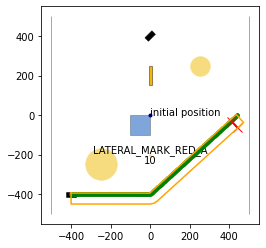

In [8]:
cartesian_point = np.array([438.0,-60.0])
project_and_plot(curvilinear_cosy, cartesian_point)